# k-NN, Decision Tree, Random Forest, SVM, Neural Network + Bagging, Boosting, CV, Grid Search

##### Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
import warnings # to silence convergence warnings

##### Functions from the exercises

In [5]:
def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

def normalize(X):
    '''
    Function for normalizing the columns (variables) of a data matrix to unit length.
    Returns the normalized data and the L2 norm of the variables 
    
    Input  (X) --------> The data matrix to be normalized 
    Output (X_pre)-----> The normalized data matrix 
    Output (d) --------> Array with the L2 norms of the variables 
    '''
    d = np.linalg.norm(X,axis=0,ord=2)  # d is the euclidian lenghts of the variables 
    d[d==0]=1                           # Avoid dividing by zero if column L2 norm is zero 
    X_pre = X / d                       # Normalize the data with the euclidian lengths
    return X_pre,d                      # Return normalized data and the euclidian lengths

def weighted_knn(K, X, n):
    yhat = np.zeros(n)
    distances = np.zeros(n)
    # For each obs, compare distance to all other points in X
    for i in range(n):
        for j in range(n):
            distances[j] = distance.euclidean(X[i,:], X[j, :])

        # Sort all the distances
        idx = np.argsort(distances)[1:(K + 1)] # Skip first, as distance to "itself" does not make sense
        Wt = sum(distances[idx]) # Weight of k nearest neighbors
        W = distances[idx] / Wt # Weighing average


        yhat[i] = np.matmul(W.T, y[idx]) # Final value is weighted combination of neighbours
    
    return yhat



In [6]:
from sklearn.base import BaseEstimator, RegressorMixin

class WeightedKNNRegressor(BaseEstimator, RegressorMixin):
	def __init__(self, K):
		self.K = K

	def fit(self, X, y):
		self.X = X
		self.y = y

	def predict(self, X):
		n = X.shape[0]
		yhat = np.zeros(n)
		for i in range(n):
			distances = np.array([distance.euclidean(X[i], x) for x in self.X])
			idx = np.argsort(distances)[:self.K]
			Wt = sum(distances[idx])
			W = distances[idx] / Wt
			yhat[i] = np.dot(W, self.y[idx])
		return yhat

##### Load and format data

In [7]:
data = pd.read_csv('./Data/case1Data.csv')
y = np.array(data['y'])
X = np.array(data.drop('y', axis=1).fillna(data.mean()))
data = pd.read_csv('./Data/case1Data_Xnew.csv')
X_new = np.array(data.fillna(data.mean()))

In [8]:
def encode_categorical(X):
    # Round the last 5 columns to integers
    X[:, -5:] = np.round(X[:, -5:])

    # Convert to integers, then to strings to force categorical treatment
    cat_data = X[:, -5:].astype(int).astype(str)
    cat_df = pd.DataFrame(cat_data)
    cat = pd.get_dummies(cat_df).values

    # Separate numerical columns
    num = X[:, :-5]
    # Standardize numerical columns
    num, mu = centerData(num)
    num, d = normalize(num)   

    # Concatenate numerical and one-hot encoded categorical columns
    X = np.concatenate((num, cat), axis=1)

    print("Final X shape:", X.shape)

    return X

def standardize_numerical(X, y=None):
    
    # Standardize numerical columns
    X, mu = centerData(X)
    X, d = normalize(X)    
    if y is not None:
        y = centerData(y)[0]
    
    # Concatenate numerical and one-hot encoded categorical columns
    return X, y


In [9]:
X = encode_categorical(X)
# X, _ = standardize_numerical(X)
X_new = encode_categorical(X_new)

Final X shape: (100, 116)
Final X shape: (1000, 116)


In [10]:
pca = PCA(n_components=0.9)
pca_plot = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca_plot = pca_plot.fit_transform(X)

X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y, test_size=0.2, random_state=1312)

In [11]:

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1312)

(100, 116)
(100,)


##### Analyses

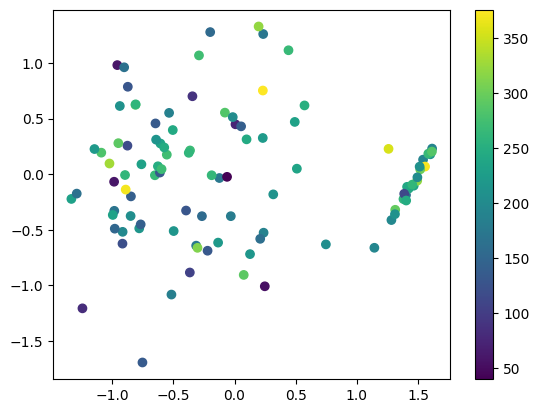

In [12]:
# Plot pca

plt.scatter(X_pca_plot[:,0], X_pca_plot[:,1], c=y, cmap='viridis')
plt.colorbar()
plt.show()

#### Model selection

In [13]:
# Model defitinions
rf = RandomForestRegressor(random_state=1312)
dt = DecisionTreeRegressor(random_state=1312)
svr = SVR()
ada = AdaBoostRegressor(random_state=1312)
bag = BaggingRegressor(random_state=1312)
dt = DecisionTreeRegressor(random_state=1312)
knn = WeightedKNNRegressor(5)
ols = LinearRegression() 
rr = Ridge() 
lasso = Lasso()
elnet = ElasticNet()



Best parameters for RandomForest: {'max_depth': None, 'n_estimators': 200}
Best RMSE for RandomForest: 50.624372948323455
Best parameters for DecisionTree: {'max_depth': 10}
Best RMSE for DecisionTree: 63.43417450568811
Best parameters for SVR: {'C': 10, 'gamma': 'scale'}
Best RMSE for SVR: 72.28087304634006
Best parameters for KNN: {'K': 5}
Best RMSE for KNN: 72.44664244514101
Best parameters for AdaBoost: {'n_estimators': 500}
Best RMSE for AdaBoost: 48.45003082170822
Best parameters for Bagging: {'n_estimators': 500}
Best RMSE for Bagging: 50.25410894404258
OLS does not have hyperparameters to tune. Model trained directly.
Best parameters for Ridge: {'alpha': np.float64(0.05134832907437552)}
Best RMSE for Ridge: 48.97880795861615
Best parameters for Lasso: {'alpha': np.float64(0.1673725413919162)}
Best RMSE for Lasso: 31.626512098376352
Best parameters for ElasticNet: {'alpha': np.float64(0.1673725413919162), 'l1_ratio': np.float64(1.0)}
Best RMSE for ElasticNet: 31.626512098376352


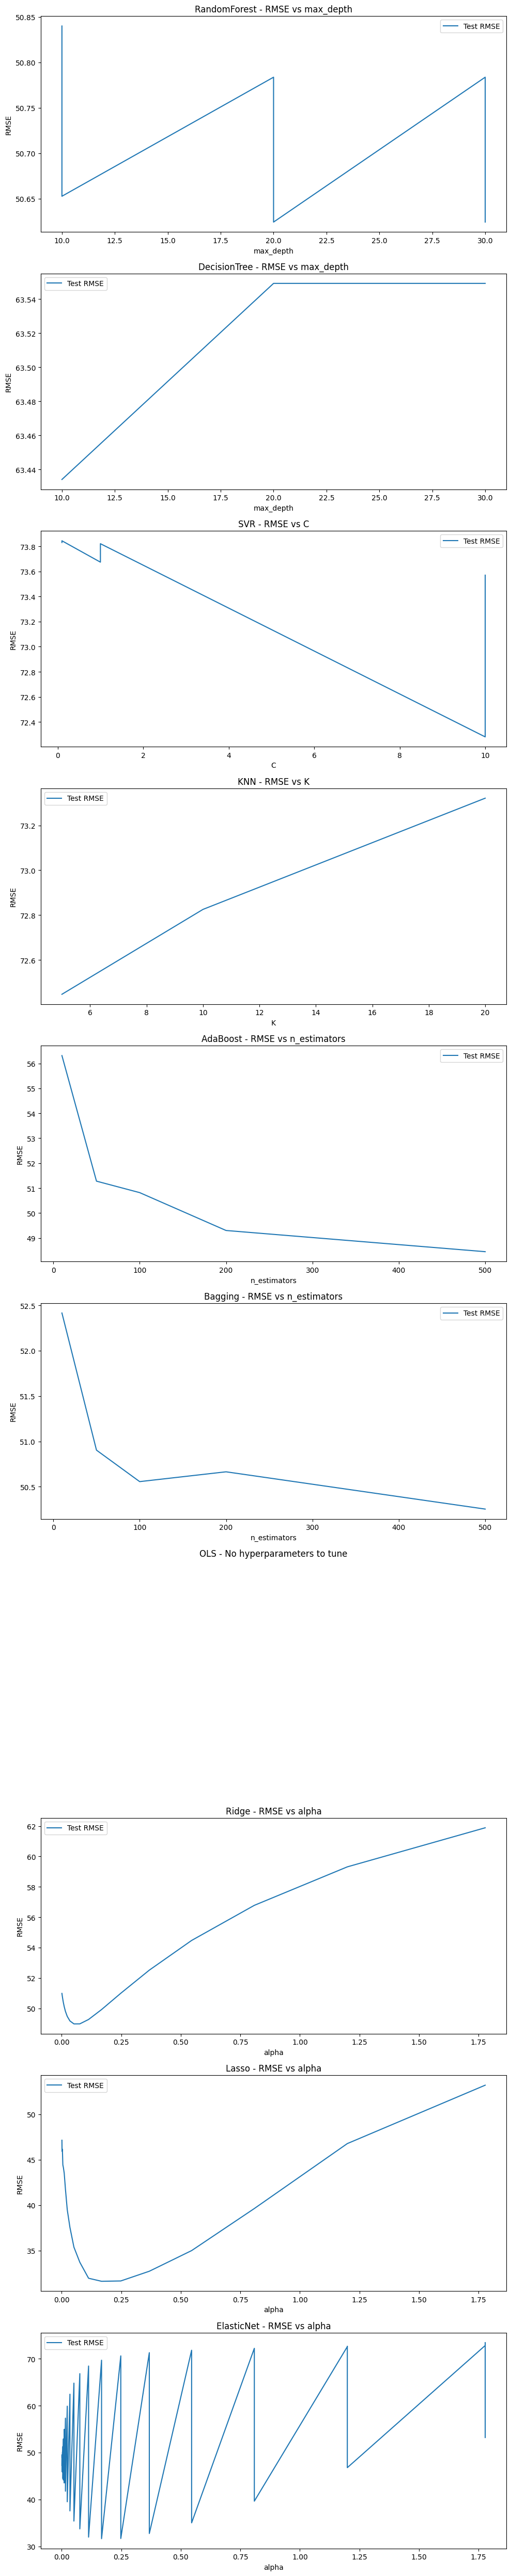

RMSE for AdaBoost with boosting: 49.42806943271866
RMSE for GradientBoosting with boosting: 44.924107468305564
RMSE for ols with boosting: 56.493831213439286
RMSE for Ridge with boosting: 57.8131153423295
RMSE for Lasso with boosting: 37.11136219027128
RMSE for RandomForest with bagging: 55.65912386236384
RMSE for DecisionTree with bagging: 51.234956048233684
RMSE for KNN with bagging: 74.27008730781225
RMSE for OLS with bagging: 50.459848535946705
RMSE for Ridge with bagging: 51.87634172660902
RMSE for Lasso with bagging: 37.384211048390775


In [14]:
# Cross validation, bagging, boosting and oob for optimization

# Define the models and their parameter grids
models = {
    'RandomForest': (RandomForestRegressor(random_state=1312), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}),
    'DecisionTree': (DecisionTreeRegressor(random_state=1312), {'max_depth': [None, 10, 20, 30]}),
    'SVR': (SVR(), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}), 
    'KNN': (WeightedKNNRegressor(K=5), {'K': [5, 10, 20]}), 
    'AdaBoost': (AdaBoostRegressor(random_state=1312), {'n_estimators': [10, 50, 100, 200, 500]}), 
    'Bagging': (BaggingRegressor(random_state=1312), {'n_estimators': [10, 50, 100, 200, 500]}),
    'OLS': (LinearRegression(), {}),
    'Ridge': (Ridge(), {'alpha': np.logspace(-3, 0.25, num=20)}),
    'Lasso': (Lasso(), {'alpha': np.logspace(-3, 0.25, num=20)}),
    'ElasticNet': (ElasticNet(), {'alpha': np.logspace(-3, 0.25, num=20), 'l1_ratio': np.linspace(0, 1, num=10)})
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Perform grid search for each model
    best_estimators = {}
    results = {}
    for name, (model, params) in models.items():
        if not params:  # If the parameter grid is empty, skip GridSearchCV
            model.fit(X_train, y_train)
            best_estimators[name] = model
            results[name] = None  # No results for models without hyperparameter tuning
            print(f"{name} does not have hyperparameters to tune. Model trained directly.")
        else:
            grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
            grid_search.fit(X_train, y_train)
            best_estimators[name] = grid_search.best_estimator_
            results[name] = grid_search.cv_results_
            print(f"Best parameters for {name}: {grid_search.best_params_}")
            print(f"Best RMSE for {name}: {np.sqrt(-grid_search.best_score_)}")
    # Plotting the RMSE for each model
    fig, axes = plt.subplots(len(models), 1, figsize=(10, 5 * len(models)))
    if len(models) == 1:
        axes = [axes]

    for ax, (name, result) in zip(axes, results.items()):
        if result is None:  # Skip plotting for models without hyperparameter tuning
            ax.axis('off')
            ax.set_title(f'{name} - No hyperparameters to tune')
            continue

        param_name = list(result['params'][0].keys())[0]
        param_range = [params[param_name] for params in result['params']]
        mean_test_score = np.sqrt(-result['mean_test_score'])
        
        ax.plot(param_range, mean_test_score, label='Test RMSE')
        ax.set_title(f'{name} - RMSE vs {param_name}')
        ax.set_xlabel(param_name)
        ax.set_ylabel('RMSE')
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Use boosting to improve the results
    boosted_models = {
        'AdaBoost': AdaBoostRegressor(estimator=best_estimators['DecisionTree'], n_estimators=100, random_state=1312),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=1312),
        'ols': AdaBoostRegressor(estimator=best_estimators['OLS'], n_estimators=100, random_state=1312),
        'Ridge': AdaBoostRegressor(estimator=best_estimators['Ridge'], n_estimators=100, random_state=1312),
        'Lasso': AdaBoostRegressor(estimator=best_estimators['Lasso'], n_estimators=100, random_state=1312)
    }

    # Evaluate the boosted models using cross-validation
    for name, model in boosted_models.items():
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-scores)
        print(f"RMSE for {name} with boosting: {rmse_scores.mean()}")

    # Use bagging and cross-validation to estimate the RMSE generalization error
    bagging_models = {
        'RandomForest': BaggingRegressor(estimator=best_estimators['RandomForest'], n_estimators=10, random_state=1312),
        'DecisionTree': BaggingRegressor(estimator=best_estimators['DecisionTree'], n_estimators=10, random_state=1312),
        'KNN': BaggingRegressor(estimator=best_estimators['KNN'], n_estimators=10, random_state=1312),
        'OLS': BaggingRegressor(estimator=best_estimators['OLS'], n_estimators=10, random_state=1312), # Not recommended
        'Ridge': BaggingRegressor(estimator=best_estimators['Ridge'], n_estimators=10, random_state=1312),
        'Lasso': BaggingRegressor(estimator=best_estimators['Lasso'], n_estimators=10, random_state=1312),
    }

    for name, model in bagging_models.items():
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-scores)
        print(f"RMSE for {name} with bagging: {rmse_scores.mean()}")

In [15]:
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
# # Perform grid search for each model
#     best_estimators_pca = {}
#     for name, (model, params) in models.items():
#         grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error')
#         grid_search.fit(X_pca_train, y_pca_train)
#         best_estimators_pca[name] = grid_search.best_estimator_
#         print(f"Best parameters for {name} with PCA: {grid_search.best_params_}")

#     # Use boosting to improve the results
#     boosted_models_pca = {
#         'AdaBoost': AdaBoostRegressor(estimator=best_estimators_pca['DecisionTree'], n_estimators=100, random_state=1312),
#         'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=1312),
#         'ols': AdaBoostRegressor(estimator=best_estimators_pca['OLS'], n_estimators=100, random_state=1312),
#         'Ridge': AdaBoostRegressor(estimator=best_estimators_pca['Ridge'], n_estimators=100, random_state=1312),
#         'Lasso': AdaBoostRegressor(estimator=best_estimators_pca['Lasso'], n_estimators=100, random_state=1312)
#     }

#     # Evaluate the boosted models using cross-validation
#     for name, model in boosted_models_pca.items():
#         scores_pca = cross_val_score(model, X_pca_train, y_pca_train, cv=5, scoring='neg_mean_squared_error')
#         rmse_scores_pca = np.sqrt(-scores_pca)
#         print(f"RMSE for {name} with boosting and PCA: {rmse_scores_pca.mean()}")

#     # Use bagging and cross-validation to estimate the RMSE generalization error
#     bagging_models_pca = {
#         'RandomForest': BaggingRegressor(estimator=best_estimators_pca['RandomForest'], n_estimators=10, random_state=1312),
#         'DecisionTree': BaggingRegressor(estimator=best_estimators_pca['DecisionTree'], n_estimators=10, random_state=1312),
#         'KNN': BaggingRegressor(estimator=best_estimators_pca['KNN'], n_estimators=10, random_state=1312),
#         'OLS': BaggingRegressor(estimator=best_estimators_pca['OLS'], n_estimators=10, random_state=1312), # Not recommended
#         'Ridge': BaggingRegressor(estimator=best_estimators_pca['Ridge'], n_estimators=10, random_state=1312),
#         'Lasso': BaggingRegressor(estimator=best_estimators_pca['Lasso'], n_estimators=10, random_state=1312)
#     }

#     for name, model in bagging_models_pca.items():
#         scores_pca = cross_val_score(model, X_pca_train, y_pca_train, cv=5, scoring='neg_mean_squared_error')
#         rmse_scores_pca = np.sqrt(-scores_pca)
#         print(f"RMSE for {name} with bagging and PCA: {rmse_scores_pca.mean()}")

In [16]:
# # Evaluate the best models on the test set
# for name, model in best_estimators.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     print(f"RMSE for {name} on test set: {rmse}")

# print("")

# for name, model in best_estimators_pca.items():
#     model.fit(X_pca_train, y_pca_train)
#     y_pred_pca = model.predict(X_pca_test)
#     rmse_pca = np.sqrt(mean_squared_error(y_pca_test, y_pred_pca))
#     print(f"RMSE for {name} on test set with PCA: {rmse_pca}")

# print("")
# print(f"RMSE for {name} on test set: {np.min(rmse)}")
# print(f"RMSE for {name} on test set with PCA: {np.min(rmse_pca)}")

In [17]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.base import clone

def compute_epe_with_small_labeled(model, X_labeled, y_labeled, X_unlabeled, n_bootstraps=100):
    """
    Compute EPE decomposition (σₑ² + Bias² + Variance) using a small labeled subset and unlabeled data.
    
    Args:
        model: Pre-trained Lasso model (used for hyperparameters and σₑ²).
        X_labeled: Labeled subset features (shape: [n_labeled_samples, n_features]).
        y_labeled: Labeled subset targets (shape: [n_labeled_samples]).
        X_unlabeled: Unlabeled data features (shape: [n_unlabeled_samples, n_features]).
        n_bootstraps: Number of bootstrap iterations (default: 100).
    
    Returns:
        epe: Total Expected Prediction Error.
        sigma_e_sq: Irreducible error.
        bias_sq: Squared bias.
        variance: Prediction variance.
    """
    # Step 1: Compute irreducible error (σₑ²) using the labeled subset
    y_pred_labeled = model.predict(X_labeled)
    sigma_e_sq = np.var(y_labeled - y_pred_labeled, ddof=1)  # Unbiased estimate

    # Step 2: Bootstrap training on the labeled subset to estimate bias and variance
    n_labeled = X_labeled.shape[0]
    n_unlabeled = X_unlabeled.shape[0]
    
    # Arrays to store predictions for labeled and unlabeled data
    preds_labeled = np.zeros((n_bootstraps, n_labeled))
    preds_unlabeled = np.zeros((n_bootstraps, n_unlabeled))

    for i in range(n_bootstraps):
        # Create bootstrap sample
        indices = np.random.choice(n_labeled, n_labeled, replace=True)
        X_boot, y_boot = X_labeled[indices], y_labeled[indices]
        
        # Clone model to retain hyperparameters and train on bootstrap sample
        m = clone(model)
        m.fit(X_boot, y_boot)
        
        # Predict on labeled and unlabeled data
        preds_labeled[i] = m.predict(X_labeled)
        preds_unlabeled[i] = m.predict(X_unlabeled)

    # Step 3: Compute bias² (using labeled subset)
    mean_preds_labeled = np.mean(preds_labeled, axis=0)
    bias_sq = np.mean((mean_preds_labeled - y_labeled) ** 2)

    # Step 4: Compute variance (using unlabeled data)
    variance = np.mean(np.var(preds_unlabeled, axis=0, ddof=1))

    # Step 5: Total EPE
    epe = sigma_e_sq + bias_sq + variance

    return epe, sigma_e_sq, bias_sq, variance

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the range of alphas for Lasso
alphas = np.logspace(-3, 3, 20)  # Example range of alpha values
K = 5  # Number of cross-validation folds

# Store RMSE for each alpha
RMSE = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Perform cross-validation for each alpha
    for alpha in alphas:
        model = Lasso(alpha=alpha, max_iter=10000)
        scores = cross_val_score(model, X_train, y_train, cv=K, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-scores)  # Convert negative MSE to RMSE
        RMSE.append(rmse_scores)

    RMSE = np.array(RMSE)
    meanRMSE = np.mean(RMSE, axis=1)  # Mean RMSE for each alpha
    jOpt = np.argmin(meanRMSE)  # Index of the optimal alpha (smallest RMSE)

# Calculate the standard error for the best alpha
seRMSE = np.std(RMSE, axis=1) / np.sqrt(K)

# Find the largest alpha within one standard error of the optimal alpha
J = np.where(meanRMSE[jOpt] + seRMSE[jOpt] > meanRMSE)[0]
Alpha_CV_1StdRule = alphas[J[-1]]

print(f"Optimal alpha: {alphas[jOpt]:.4f}")
print(f"CV alpha with 1-std-rule: {Alpha_CV_1StdRule:.4f}")

# Train the final model with the selected alpha
final_model = Lasso(alpha=Alpha_CV_1StdRule, max_iter=10000)
final_model.fit(X_train, y_train)

# Evaluate the final model on the test set
final_rmse = np.sqrt(mean_squared_error(y_test, final_model.predict(X_test)))
print(f"Final RMSE on test set: {final_rmse:.4f}")

epe, std, bias, var = compute_epe_with_small_labeled(final_model, X_train, y_train, X_new)


print(f"Expected Prediction Error (EPE): {epe:.4f}")
print(f"Irreducible Error (σₑ²): {std:.4f}")
print(f"Bias²: {bias:.4f}")
print(f"Variance: {var:.4f}")


# Predict on X_new using the final model
y_new_pred = final_model.predict(X_new)

# Save the predicted values to a CSV file
#np.savetxt('sample_estimate_prediction_s215160.csv', y_new_pred, delimiter=',', fmt='%f')

Optimal alpha: 0.1624
CV alpha with 1-std-rule: 0.3360
Final RMSE on test set: 38.1111
Expected Prediction Error (EPE): 1181.0553
Irreducible Error (σₑ²): 365.1533
Bias²: 535.1325
Variance: 280.7695


In [19]:
# Expected RMSE

rmse_hat = np.sqrt(epe)

print(f"Expected RMSE: {rmse_hat:.4f}")

Expected RMSE: 34.3665
